<a href="https://colab.research.google.com/github/SushantSingh-23-01/Image_Gen/blob/main/WGan_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN Implementation for generating new pokemon Images

## 0 Loading Libraries

In [1]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
from tqdm.auto import tqdm
from dataclasses import dataclass
import matplotlib.pyplot as plt

## 1. Data Loading

### 1.0 Custom Image Dataset

In [27]:
class ImageDataset(Dataset):
    def __init__(self, dataset_path, img_size) -> None:
        self.dataset_path = dataset_path
        self._get_file_dir()
        self.img_size = img_size

    def _get_file_dir(self):
        self.filenames = []
        for path, subdirs, files in os.walk(self.dataset_path):
            for name in files:
                if name.endswith('.png'):
                    self.filenames.append(os.path.join(path, name))
        self.filenames = self.filenames[:1000]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index:int):
        image = Image.open(self.filenames[index])
        transform  = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.CenterCrop(self.img_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3]),
            # Comment out when calculating dataset mean and std
            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))   # Mean -> R, G, B ; Std -> R, G, B
        ])
        image = transform(image)
        return image

### 1.1 Mean & Standard Deviation of Dataset

In [3]:
class Dataset_statistics:
    def __init__(self, path:str, dataset) -> None:
        self.path = path
        self.dataset = dataset
        self.mean = 0.0
        self.std = 0.0
        self.img_count = 0.0

    def __call__(self):
        loader = DataLoader(self.dataset)
        for img in tqdm(loader):
            batch_size = img.shape[0]
            img = img.view(batch_size, img.shape[1], -1)
            self.mean += torch.sum(torch.mean(img, dim=-1), dim=0)
            self.std += torch.sum(torch.std(img, dim=-1), dim=0)
            self.img_count += batch_size
        self.mean /= self.img_count
        self.std /= self.img_count
        return self.mean.detach().cpu(), self.std.detach().cpu()

## 2. Model

### 2.1 Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim:int, gen_dim:int, img_ch:int)->None:
        super(Generator, self).__init__()
        self.convt1 = nn.ConvTranspose2d(in_channels=latent_dim, out_channels=gen_dim * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=gen_dim * 8)
        self.act1 = nn.ReLU()

        self.convt2 = nn.ConvTranspose2d(in_channels=gen_dim*8, out_channels=gen_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=gen_dim * 4)
        self.act2 = nn.ReLU()

        self.convt3 = nn.ConvTranspose2d(in_channels=gen_dim*4, out_channels=gen_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=gen_dim * 2)
        self.act3 = nn.ReLU()

        self.convt4 = nn.ConvTranspose2d(in_channels=gen_dim*2, out_channels=gen_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(num_features=gen_dim)
        self.act4 = nn.ReLU()

        self.convt5 = nn.ConvTranspose2d(in_channels=gen_dim, out_channels=img_ch, kernel_size=4, stride=2, padding=1, bias=False)
        self.act_out = nn.Tanh()

        self.latent_dim = latent_dim
        self.img_ch = img_ch

        self._init_params()

    def forward(self, x):
        # convt2d-> out_shape = (in_shape - 1) x stride + kernel_size - 2 * pad_size
        # x -> B, LD, 1, 1 -> B, GD * 16, 4, 4
        x = self.act1(self.bn1(self.convt1(x)))
        # x -> B, GD * 8, 8, 8
        x = self.act2(self.bn2(self.convt2(x)))
        # x -> B, GD * 4, 16, 16
        x = self.act3(self.bn3(self.convt3(x)))
        # x -> B, GD * 2, 32, 32
        x = self.act4(self.bn4(self.convt4(x)))
        # x -> B, C, 64, 64
        x = self.act_out(self.convt5(x))
        return x

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
               nn.init.normal_(m.weight, 0.0, 0.02)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

### 2.2 Critic

In [5]:
class Critic(nn.Module):
    def __init__(self, disc_dim:int, img_ch:int)->None:
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=img_ch, out_channels=disc_dim, kernel_size=4, stride=2, padding=1,bias=False)
        self.act1 = nn.LeakyReLU(negative_slope=0.2)

        self.conv2 = nn.Conv2d(in_channels=disc_dim, out_channels=disc_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.act2 = nn.LeakyReLU(negative_slope=0.2)
        self.bn2 = nn.BatchNorm2d(num_features=disc_dim*2)

        self.conv3 = nn.Conv2d(in_channels=disc_dim*2, out_channels=disc_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.act3 = nn.LeakyReLU(negative_slope=0.2)
        self.bn3 = nn.BatchNorm2d(num_features=disc_dim*4)

        self.conv4 = nn.Conv2d(in_channels=disc_dim*4, out_channels=disc_dim*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.act4 = nn.LeakyReLU(negative_slope=0.2)
        self.bn4 = nn.BatchNorm2d(num_features=disc_dim*8)


        self.conv5 = nn.Conv2d(in_channels=disc_dim*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
        self.act_out = nn.LeakyReLU(0.2)

        self._init_params()

    def forward(self, x):
        # out_shape = floor[(in_size + 2 * pad_size - kernel_size) / stride] + 1
        # x -> B x C x H x W -> B, 1, 64, 64 -> B, DC, 32, 32
        x = self.act1(self.conv1(x))
        # x -> B, DC * 2, 16, 16
        x = self.bn2(self.act2(self.conv2(x)))
        # x ->  B, DC, 8, 8
        x = self.bn3(self.act3(self.conv3(x)))
        # x ->  B, 1, 4, 4
        x = self.bn4(self.act4(self.conv4(x)))
        # x -> B, 1, 1, 1
        x = self.act_out(self.conv5(x))
        # x - > B
        return x.flatten()

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
               nn.init.normal_(m.weight, 0.0, 0.02)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

## 3. AutoTrainer

<h2>WGAN Concepts:</h2> <br>
Wasserstein Generative Adversarial Networks were introduced to mitigate mode collapse issue with normal GANs, when Generator focuses on producing a limited set of data patterns that deceive the discriminator. It becomes fixated on a few dominant modes in the training data and fails to capture the full diversity of the data distribution <br>
WGANs use the Wasserstein distance, which provides a more meaningful and smoother measure of distance between distributions.<br>
The benefit of having Wasserstein Distance instead of Jensen-Shannon (JS) or Kullback-Leibler divergence is as follows:<br>
- W (Pr, Pg) is continuous.<br>
- W (Pr, Pg) is differential everywhere.<br>
- Whereas Jensen-Shannon divergence and other divergence or variance are not continuous, but rather discrete.<br>

Discriminator Loss : $$\quad max(D(x) - D(G(z))),$$
<br> i.e Maximizie distance between orignal data prediction and fake data prediction.<br><br>
Generator Loss: $$\quad max(D(G(z))),$$<br> i.e Maximize Likelihood of fooling discriminator using generator's generations.

*Notes:* Here discriminator training is restricted to have bounded Lipschitz norm. This is achieved by:
- Weight clipping: by clipping all the entries of *W* with soome interval $[-c\;,\;c]$, we can have bound $\parallel W \parallel_s$

In [35]:
class Trainer:
    def __init__(self, generator, critic, optimizerG, optimizerD, dataloader, num_epochs:int, device, model_save_path:str, model_load_path:str, critic_step:int=1, weight_clipping_value:float|None=None, gradient_penalty_factor:float|None=None, log_losses=False) -> None:
        self.generator = generator
        self.critic = critic
        self.optimizerG = optimizerG
        self.optimizerD = optimizerD
        self.dataloader = dataloader

        self.num_epochs = num_epochs
        self.device =device

        self.latent_dim = generator.latent_dim
        self.img_ch = generator.img_ch

        self.model_save_path = model_save_path
        self.model_load_path = model_load_path

        self.critic_step = critic_step
        self.weight_clipping_value = weight_clipping_value
        self.gradient_penalty_factor = gradient_penalty_factor

        self.log_losses = log_losses

        if self.log_losses is True:
            self.G_losses = []
            self.D_losses = []

        self.G_grads_mean = []
        self.G_grads_std = []

    def save_checkpoint(self):
        torch.save({
            'gen_state_dict':self.generator.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'optimizerG_state_dict':self.optimizerG.state_dict(),
            'optimizerD_state_dict': self.optimizerD.state_dict(),
        }, self.model_save_path)

    def load_checkpoint(self):
        checkpoint = torch.load(self.model_load_path,map_location=self.device, weights_only=True)
        self.generator.load_state_dict(checkpoint['gen_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
        self.optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

    def apply_gradient_penalty(self, real, fake):
        batch_size, img_ch, height, width = real.shape
        epsilon = torch.rand((batch_size, 1, 1, 1), device=self.device).repeat(1, img_ch, height, width)

        interpolated_images = epsilon * real + (1-epsilon) * fake
        mixed_scores = self.critic(interpolated_images)

        gradient = torch.autograd.grad(
            inputs = interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores),
            create_graph=True,
            retain_graph=True
        )[0]
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = torch.norm(gradient, p=2, dim=-1)
        gradient_penalty = torch.mean(torch.pow((gradient_norm - 1),2))
        return gradient_penalty

    def train(self):
        if self.model_load_path is not None:
            self.load_checkpoint()
        try:

            self.critic.train()
            self.generator.train()
            for epoch in tqdm(range(self.num_epochs)):
                for i, real_image in enumerate(self.dataloader):
                    # Critic Loss: max(D(x) - D(G(z))) <-> min(-(D(x) - D(G(z)))
                    # Generator loss : max(D(G(z)))
                    self.critic.zero_grad()
                    real_image = real_image.to(self.device)
                    batch_size = real_image.shape[0]

                    crit_real = self.critic(real_image).view(-1)
                    D_x = crit_real.mean()

                    noise = torch.randn((batch_size, self.latent_dim, 1, 1), device=self.device)
                    fake_image  = self.generator(noise)

                    crit_fake = self.critic(fake_image.detach()).view(-1)
                    D_G_z1 = crit_fake.mean()

                    if self.gradient_penalty_factor is not None:
                        gp = self.apply_gradient_penalty(real_image, fake_image)
                        critic_loss = D_G_z1 - D_x + self.gradient_penalty_factor * gp
                    else:
                        critic_loss = D_G_z1 - D_x

                    critic_loss.backward()
                    self.optimizerD.step()

                    # clip weights
                    if self.weight_clipping_value is not None:
                        for p in self.critic.parameters():
                            p.data.clamp_(-self.weight_clipping_value, self.weight_clipping_value)

                    if i % self.critic_step == 0:
                        self.generator.zero_grad()
                        fake_image = self.generator(noise)
                        crit_fake = self.critic(fake_image).view(-1)
                        gen_loss = -crit_fake.mean()
                        gen_loss.backward()
                        self.optimizerG.step()


                    for param in self.critic.parameters():
                        disc_grad_avg = param.grad.view(-1).mean().detach().cpu()

                    for param in self.generator.parameters():
                        gen_grad_avg = param.grad.view(-1).mean().detach().cpu()


                    if i % (50) == 0:
                        print(f'\nEpoch : {epoch+1} / {self.num_epochs} | iter : {i} / {len(self.dataloader)} | disc loss : {critic_loss.item():.4f} | D(x): {D_x:.4f} | D(G(z)) : {D_G_z1:.4f} / {gen_loss:.4f} | disc_grad_mean : {disc_grad_avg:.2e} | gen_grad_mean : {gen_grad_avg:.2e}\n')

        except KeyboardInterrupt:
            self.save_checkpoint()
        self.save_checkpoint()

    def plot_losses(self):
        plt.title('Loss Curves for generator and discriminator')
        plt.plot(self.G_losses, label='Non-saturating G loss')
        plt.plot(self.D_losses, label='Non-saturating D loss')
        plt.xlabel('Iterations')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

In [86]:
@dataclass
class mconfig:
    img_size = (64,64)
    img_ch = 3
    latent_dim = 100
    gen_dim = 64
    disc_dim = 64

@dataclass
class tconfig:
    lr = 1e-4
    batch_size = 32
    num_epochs = 100
    momentum_coeff = 0.0
    rmsprop_coeff = 0.9
    critic_steps = 1
    weight_clip =  0.1
    gradient_penalty_factor = 20
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_save_path = r'wgan_pok.pt'
    model_load_path = None#model_save_path

In [87]:
!unzip pokemon_images.zip -d '/content'

Archive:  pokemon_images.zip
replace /content/pokemon_images/abomasnow.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [88]:
dataset = ImageDataset(r'/content/pokemon_images', mconfig.img_size)
dataloader = DataLoader(dataset, tconfig.batch_size, shuffle= True)

In [90]:
generator = Generator(mconfig.latent_dim, mconfig.gen_dim, mconfig.img_ch).to(tconfig.device)
discriminator = Critic(mconfig.disc_dim, mconfig.img_ch).to(tconfig.device)

In [91]:
optimizerG = torch.optim.AdamW(generator.parameters(), lr = 1e-4, betas=(tconfig.momentum_coeff, tconfig.rmsprop_coeff))
optimizerD = torch.optim.AdamW(discriminator.parameters(), lr = 1e-4, betas=(tconfig.momentum_coeff, tconfig.rmsprop_coeff))

In [92]:
trainer = Trainer(generator, discriminator, optimizerG, optimizerD, dataloader,
                  tconfig.num_epochs, tconfig.device, tconfig.model_save_path, tconfig.model_load_path,
                  tconfig.critic_steps, tconfig.weight_clip, tconfig.gradient_penalty_factor)

In [ ]:
trainer.train()

In [82]:
real_batch = next(iter(dataloader))
with torch.inference_mode():
    noise = torch.randn(16, mconfig.latent_dim, 1, 1, device = tconfig.device)
    fake_img = generator(noise).detach().cpu()
    gen_images = vutils.make_grid(fake_img, nrow=4, normalize=True)

`Note`: Trained ~500 epochs.

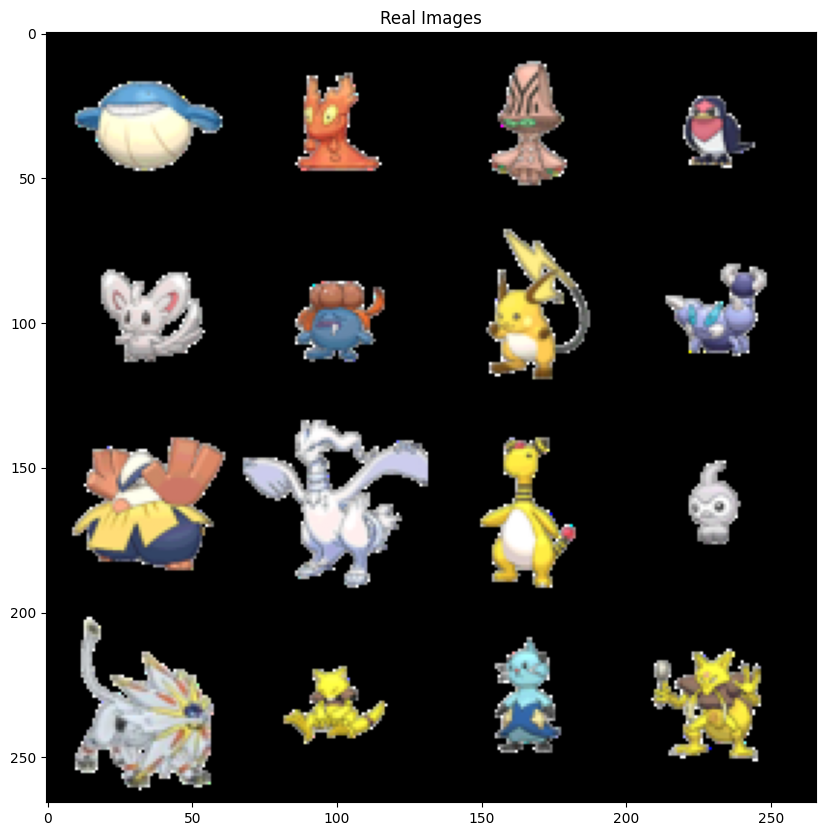

In [83]:
plt.figure(figsize=(10,10))
plt.title("Real Images")
plt.imshow(torch.permute(vutils.make_grid(real_batch[:16], nrow=4, normalize=True), (1,2,0)))
plt.show();

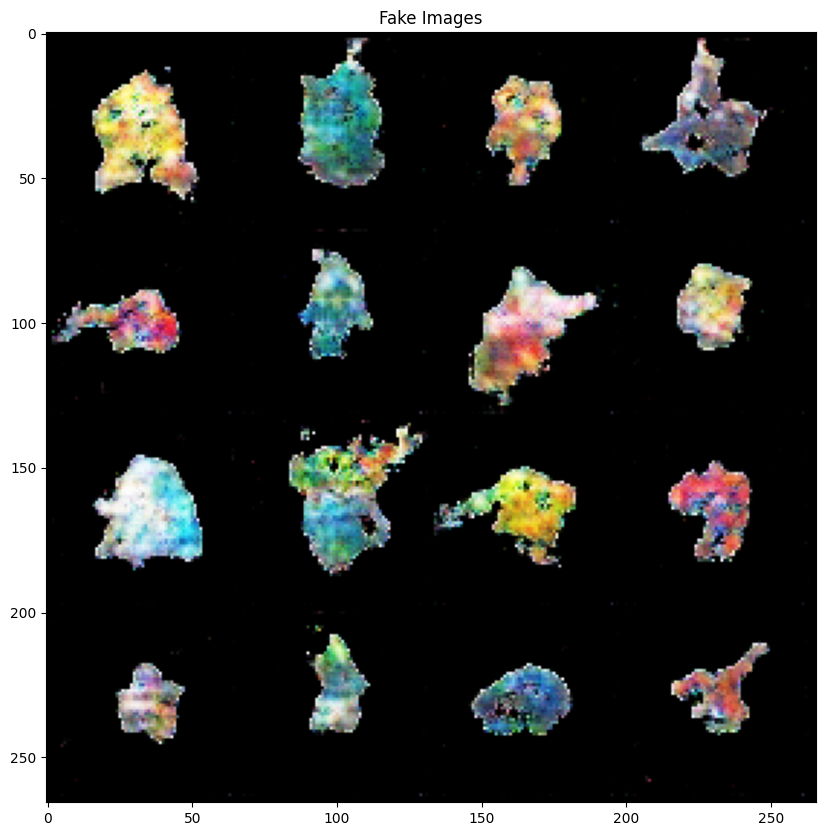

In [84]:
plt.figure(figsize=(10,10))
plt.title("Fake Images")
plt.imshow(torch.permute(gen_images, (1,2,0)))
plt.show()

In [85]:
!cp 'wgan_pokemon2.pt' '/content/drive/MyDrive/Models/wgan_pok.pt'